In [90]:

from tensorflow import keras 
import numpy as np
import matplotlib.pyplot as plt
from random import randrange as rd
from math import log 

In [91]:
fashion_mnist = keras.datasets.fashion_mnist  # load dataset

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()  # split into testing and training data 

In [92]:
train_images  = np.array(train_images)
train_try     = train_images
m_train, a, b = train_images.shape 
n_train       = a*b
train_images  = train_images.reshape(60000,n_train) # flattening the data
train_labels  = np.array(train_labels)
train_images  = train_images.T / 255 
print('train_images.shape: '+str(train_images.shape)+' train_labels: '+str(train_labels.shape))
print('n_train: '+str(n_train))

m = m_train

train_images.shape: (784, 60000) train_labels: (60000,)
n_train: 784


In [93]:

test_images  = np.array(test_images)
test_images  = test_images.reshape(10000,n_train)
test_images  = test_images.T /255
test_labels  = np.array(test_labels)
print('test_images.shape: '+str(test_images.shape)+' test_labels: '+str(test_labels.shape))

test_images.shape: (784, 10000) test_labels: (10000,)


In [94]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [95]:
### pripraveni vah 

def init():
  n1 = 10
  n2 = 8 
  n3 = 10 
  C = -0.5 # <-0.5, 0.5>
  W1 = np.random.rand(200, 784)   + C 
  W2 = np.random.rand(100, 200)   + C
  W3 = np.random.rand(10 , 100)   + C
  b1 = np.random.rand(200, 1)     + C
  b2 = np.random.rand(100, 1)     + C
  b3 = np.random.rand(10, 1)      + C

  return W1, b1, W2, b2, W3, b3

In [96]:
def ReLu(Z):
  return np.maximum(0, Z)

In [97]:
def RelU_deriv(Z):
  return Z > 0


In [98]:
def softmax(Z):
    A3 = np.exp(Z) / sum(np.exp(Z))
    return A3

In [99]:
# Dopredna propagace 'forward propagation'
#1:  x_train (A0) -> (x_train*W1 +b1) -> z1 -> RelU(z1) -> A1 
#2   A1*W2+b2 -> z2 -> RelU(z2) -> A2 
#3   A2*W3+b3 -> z3 -> softmax(z3) -> z3 == Results, given numbers from range (0 - 1), the highest number is probably the right answer 
# lets code 
def forward(X, W1, b1, W2, b2, W3, b3):
  # prvni vrstva 
  Z1 = W1.dot(X)  +b1
  A1 = ReLu(Z1)
  ## druha vrstva 
  Z2 = W2.dot(A1) +b2 
  A2 = ReLu(Z2)
  ### treti vrstva 
  Z3 = W3.dot(A2) +b3
  A3 = softmax(Z3)

  return A1, Z1, A2, Z2, A3, Z3 

In [100]:
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

In [101]:
def backward(X, Y, Z1, A1, Z2, A2 , W2, A3, W3):
    # Treti
    one_hot_Y = one_hot(Y)
    dZ3 = A3 - one_hot_Y
    dW3 = 1 / m * dZ3.dot(A2.T)
    db3 = 1 / m * np.sum(dZ3)
    # Druha
    dZ2 = W3.T.dot(dZ3) * RelU_deriv(Z2)
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    # Prvni
    dZ1 = W2.T.dot(dZ2) * RelU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2, dW3, db3

In [102]:
def update(W1, dW1, b1, db1, W2, dW2, b2, db2, W3, dW3, b3, db3, alfa):
  
  W1 = W1 - alfa*dW1
  b1 = b1 - alfa*db1
  
  W2 = W2 - alfa*dW2
  b2 = b2 - alfa*db2

  W3 = W3 - alfa*dW3
  b3 = b3 - alfa*db3

  return W1,  b1,  W2,  b2,  W3,  b3,
  

In [103]:
def get_predictions(A3):
    return np.argmax(A3, 0)

def get_accuracy(predictions, Y):
    
    return np.sum(predictions == Y) / Y.size

In [104]:
def costF(A3,Y):
  Yk = one_hot(Y)
  cost = -1/(10) * np.sum(Yk*np.log(A3))
  return cost 


In [105]:
def Gradient_Descent(X, Y, alfa, it):
    W1 ,  b1,  W2,  b2,  W3,  b3          = init() # nacteni pocatecnich hodnot
    Cost_list = []
    for j in range(it):
      A1 ,  Z1,  A2,  Z2,  A3,  Z3        = forward(X, W1, b1, W2, b2, W3, b3)
      dW1, db1, dW2, db2, dW3, db3        = backward(X, Y, Z1, A1, Z2, A2 , W2, A3, W3)
      W1 ,  b1,  W2,  b2,  W3,  b3        = update(W1, dW1, b1, db1, W2, dW2, b2, db2, W3, dW3, b3, db3, alfa)
      cost  = costF(A3,Y)
      Cost_list.append(cost)
      predictions = get_predictions(A3)
      if (j % 20 == 0):
        print("Iteration: ", j)
        print('Accuracy: ' +str(round((get_accuracy(predictions, Y)*100),3))+'[%]')
        print('Cost: '+str(round((cost),3)))
      
      
    
    return W1,  b1,  W2,  b2,  W3,  b3, Cost_list

In [106]:
iter = 2000
W1,  b1,  W2,  b2,  W3,  b3, Cost_list = Gradient_Descent(train_images, train_labels, 0.1,iter)

Iteration:  0
Accuracy: 6.122[%]
Cost: 198669.517


C:\Users\vbudo\AppData\Local\Temp\ipykernel_12228\966829016.py:3: RuntimeWarning: divide by zero encountered in log
  cost = -1/(10) * np.sum(Yk*np.log(A3))
C:\Users\vbudo\AppData\Local\Temp\ipykernel_12228\966829016.py:3: RuntimeWarning: invalid value encountered in multiply
  cost = -1/(10) * np.sum(Yk*np.log(A3))


Iteration:  20
Accuracy: 40.042[%]
Cost: 9938.237
Iteration:  40
Accuracy: 52.995[%]
Cost: 8309.475
Iteration:  60
Accuracy: 56.518[%]
Cost: 7431.155
Iteration:  80
Accuracy: 59.517[%]
Cost: 6627.313
Iteration:  100
Accuracy: 61.325[%]
Cost: 6537.214
Iteration:  120
Accuracy: 63.447[%]
Cost: 6006.362
Iteration:  140
Accuracy: 65.298[%]
Cost: 5598.977
Iteration:  160
Accuracy: 66.335[%]
Cost: 5454.524
Iteration:  180
Accuracy: 67.648[%]
Cost: 5249.355
Iteration:  200
Accuracy: 68.72[%]
Cost: 5234.546
Iteration:  220
Accuracy: 70.03[%]
Cost: 4976.003
Iteration:  240
Accuracy: 70.04[%]
Cost: 4922.332
Iteration:  260
Accuracy: 71.738[%]
Cost: 4662.612
Iteration:  280
Accuracy: 72.085[%]
Cost: 4703.586
Iteration:  300
Accuracy: 72.852[%]
Cost: 4664.617
Iteration:  320
Accuracy: 73.942[%]
Cost: 4400.688
Iteration:  340
Accuracy: 74.307[%]
Cost: 4274.545
Iteration:  360
Accuracy: 74.83[%]
Cost: 4209.549
Iteration:  380
Accuracy: 75.353[%]
Cost: 4152.832
Iteration:  400
Accuracy: 75.73[%]
Cost

In [116]:
######### Uspestnost TEST DATA #########
########################################


A1 ,  Z1,  A2,  Z2,  X_TEST,  Z3 = forward(test_images, W1, b1, W2, b2, W3, b3)
dev_predictions = get_predictions(X_TEST)
print('Accuracy_Test_data: ' +str(round((get_accuracy(dev_predictions , test_labels)*100),3))+' [%]')

Accuracy_Test_data: 82.51 [%]


<function matplotlib.pyplot.show(close=None, block=None)>

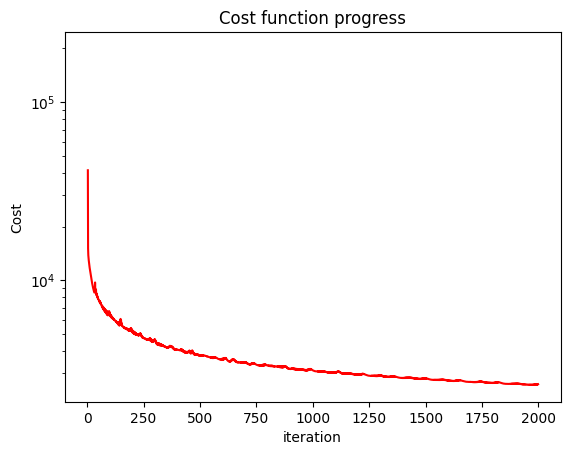

In [108]:
t = np.arange(0, iter)
plt.title("Cost function progress")
plt.plot(t,Cost_list,color='red')
plt.yscale('log')
plt.xlabel("iteration")
plt.ylabel("Cost")
plt.show


ODHAD: Pullover
SPRAVNE: Pullover
######### MATCH #########


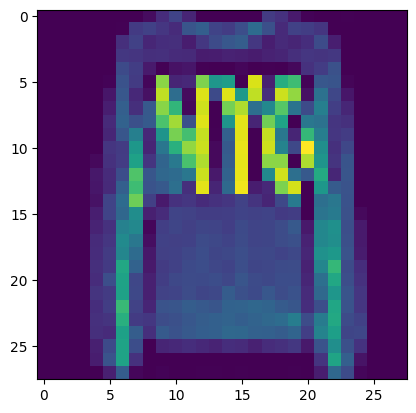

ODHAD: Sneaker
SPRAVNE: Sneaker
######### MATCH #########


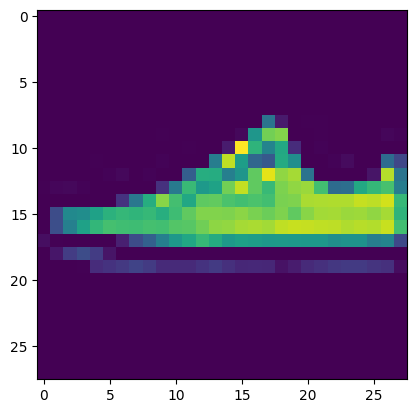

ODHAD: T-shirt/top
SPRAVNE: T-shirt/top
######### MATCH #########


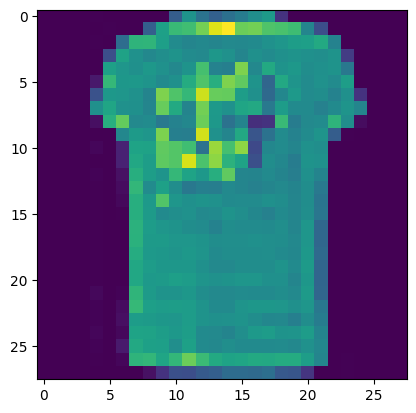

ODHAD: Shirt
SPRAVNE: Pullover
######### MISS  #########


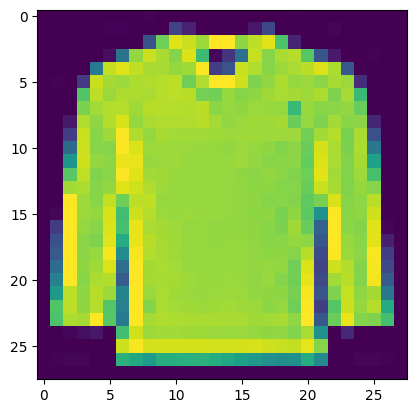

ODHAD: Ankle boot
SPRAVNE: Ankle boot
######### MATCH #########


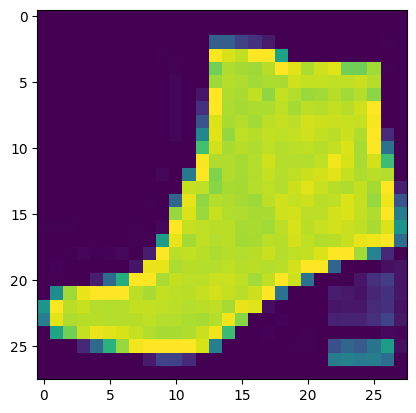

ODHAD: Bag
SPRAVNE: Bag
######### MATCH #########


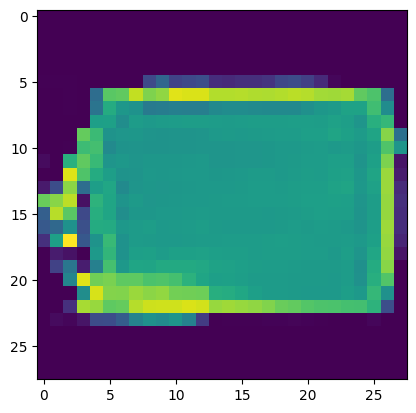

ODHAD: Trouser
SPRAVNE: Trouser
######### MATCH #########


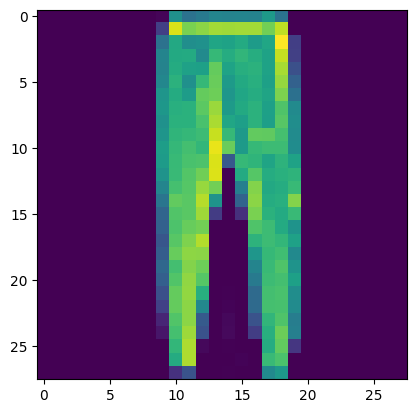

ODHAD: Shirt
SPRAVNE: Shirt
######### MATCH #########


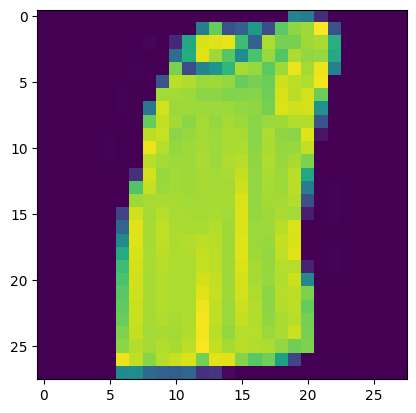

ODHAD: Bag
SPRAVNE: Bag
######### MATCH #########


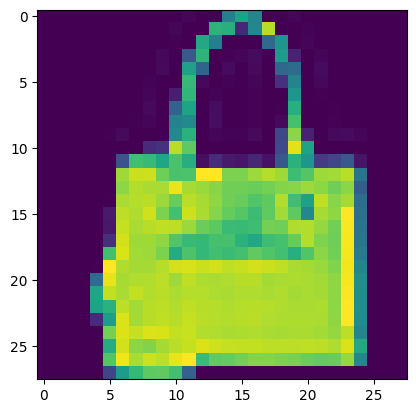

ODHAD: Coat
SPRAVNE: Coat
######### MATCH #########


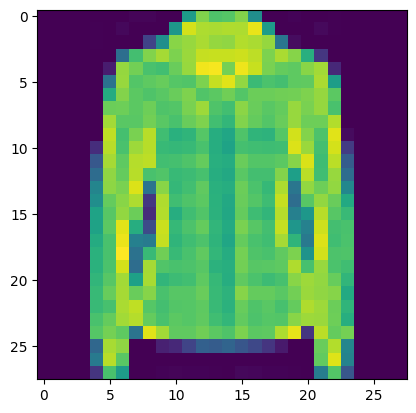

ODHAD: Trouser
SPRAVNE: Trouser
######### MATCH #########


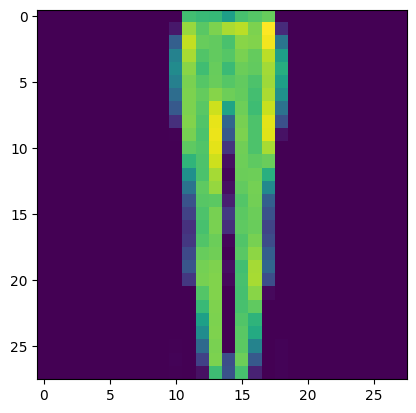

ODHAD: Sneaker
SPRAVNE: Sneaker
######### MATCH #########


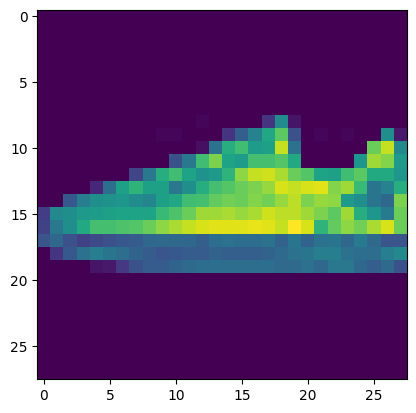

ODHAD: Pullover
SPRAVNE: Pullover
######### MATCH #########


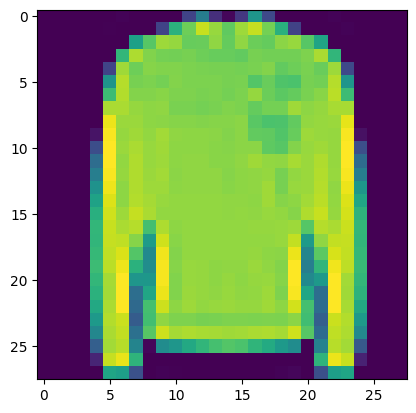

ODHAD: Pullover
SPRAVNE: Pullover
######### MATCH #########


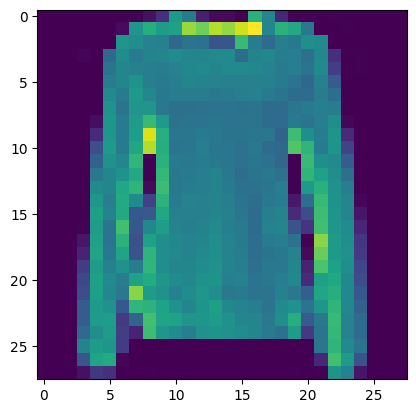

ODHAD: Ankle boot
SPRAVNE: Ankle boot
######### MATCH #########


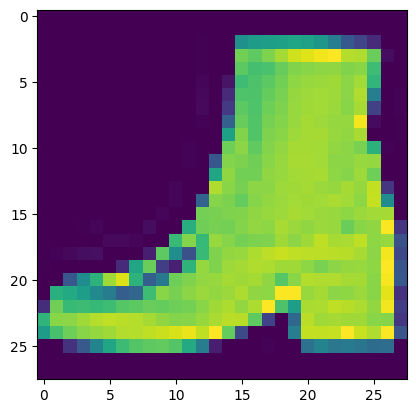

ODHAD: Pullover
SPRAVNE: Pullover
######### MATCH #########


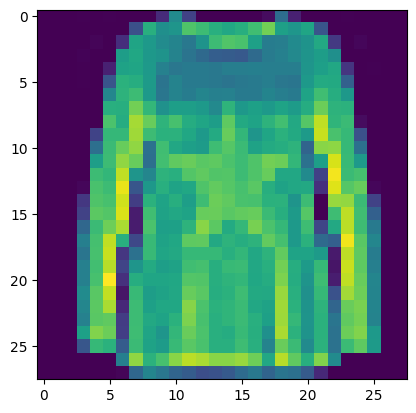

ODHAD: Bag
SPRAVNE: Bag
######### MATCH #########


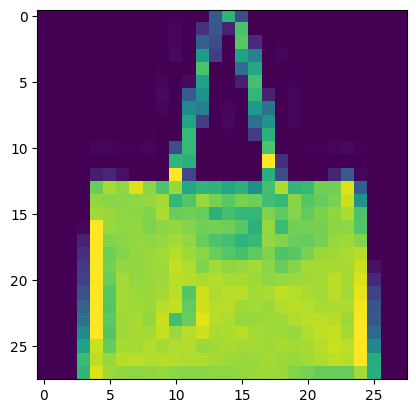

ODHAD: Ankle boot
SPRAVNE: Ankle boot
######### MATCH #########


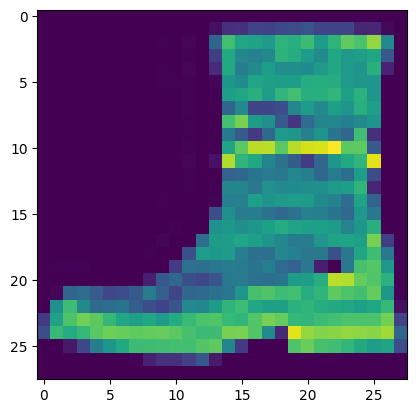

ODHAD: Dress
SPRAVNE: Dress
######### MATCH #########


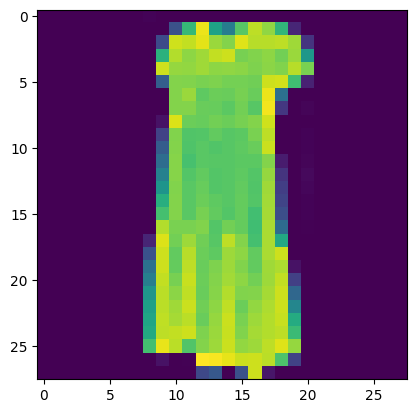

ODHAD: Dress
SPRAVNE: Dress
######### MATCH #########


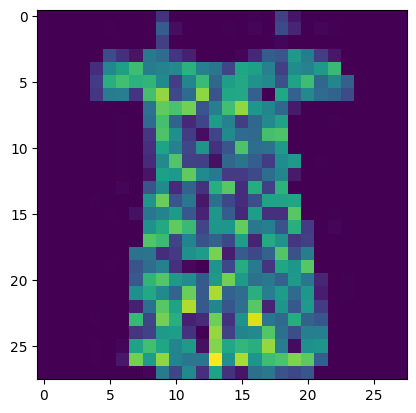

In [117]:
### random N pictures from test_set 
N = 20 
for i in range(N):
  Q = rd(10000) 
  img =  test_images[:, Q , None]

  A1 ,  Z1,  A2,  Z2,  A3,  Z3        = forward(img, W1, b1, W2, b2, W3, b3)
  TEST = get_predictions(A3)
  TEST = TEST[0]
  TEST_label = test_labels[Q]
  print('ODHAD: ' + str(class_names[TEST]))
  print('SPRAVNE: '+ str(class_names[TEST_label]))
  current_image = img.reshape((28, 28)) * 255
  if TEST == TEST_label:
    print('######### MATCH #########')
  else:
    print('######### MISS  #########')

  plt.imshow(current_image, interpolation='nearest')
  plt.show()